In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = 'Arial'
plt.rcParams.update({'font.size': 20})

In [2]:
df = pd.read_csv('shap_results.csv')
df

,can_smiles_solute,can_smiles_solvent,DGsolv,label,predicted,total_atoms_solute,total_atoms_solvent,shap_values
0,O=C1C=CC(=O)O1,Clc1ccccc1Cl,0.0,rxn8_r1,-6.260494,7,8,[ 0.50308142 -0.28108607 0.49260732 0.492607...
1,CC1=CCC2C(=O)OC(=O)C2C1,Clc1ccccc1Cl,0.0,rxn8_p1,-10.392890,12,8,[-0.88093452 -2.50393994 -0.00469713 0.358694...
2,C=CC(=C)C,Clc1ccccc1Cl,0.0,rxn8_r2,-3.046215,5,8,[-0.32084407 -1.09228783 2.83642323 1.769741...
3,O=C1C=CC(=O)O1,Clc1cccc(Cl)c1,0.0,rxn8_r1,-6.152175,7,8,[ 0.45258114 -0.14395263 0.415714 0.415714...
4,CC1=CCC2C(=O)OC(=O)C2C1,Clc1cccc(Cl)c1,0.0,rxn8_p1,-10.218453,12,8,[-0.88035622 -2.52780863 0.03709792 0.370622...
...,...,...,...,...,...,...,...,...
265,C12CCCCC1O2,ClCCl,0.0,rxn531_p2,-6.018484,7,3,[ 3.20157589 2.85313624 4.02545035 4.02...
266,O=C(OO)C1=CC=CC=C1,ClC(Cl)Cl,0.0,rxn531_r1,-8.728682,10,4,[ 0.49296603 0.33448044 0.60337952 0.083371...
267,O=C(O)C1=CC=CC=C1,ClC(Cl)Cl,0.0,rxn531_p1,-7.784437,9,4,[ 2.01996273 -3.60264464 2.11832852 -2.837925...
268,C1=CCCCC1,ClC(Cl)Cl,0.0,rxn531_r2,-4.603443,6,4,[ 0.97178482 0.97178482 0.63450433 -0.172840...


In [3]:
import numpy as np

Shap_contrib = []
for _, row in df.iterrows():
    shap_contrib = np.array([float(x) for x in row['shap_values'].replace('\n','')[1:-1].split()])
    shap_contrib = shap_contrib[0: row['total_atoms_solute']]
    shap_contrib = shap_contrib + (-7.470815 / row['total_atoms_solute'])
    
    Shap_contrib.append(shap_contrib)
df['Shap_contrib'] = Shap_contrib

In [4]:
from IPython.display import display, SVG, HTML
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit import Chem

def draw_mol_svg(mol_str, color_dict, prop, figsize=(500, 400)):
    mol = Chem.MolFromSmiles(mol_str)
    mc = Chem.Mol(mol.ToBinary())
    Chem.Kekulize(mc)
    rdDepictor.Compute2DCoords(mc)

    drawer = rdMolDraw2D.MolDraw2DSVG(*figsize)
    drawer.SetFontSize(40)
    
    n_atoms = len(mol.GetAtoms())
    assert n_atoms == len(color_dict), "{} atoms in mol, {} colors".format(n_atoms, len(color_dict))

    if color_dict is not None:
        drawer.DrawMolecule(
            mc, highlightAtoms=range(len(color_dict.keys())),
            highlightAtomColors=color_dict,
            highlightBonds=False)
    else:
        drawer.DrawMolecule(mc)

    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:', '').replace(':svg', '')
    return svg

def draw_shap(row):
    norm = mpl.colors.Normalize(
    vmin = -1.0,
    vmax = 1.0
    #vmin = min(row['Shap_contrib']),
    #vmax = max(row['Shap_contrib'])
    )
    cmap = cm.RdBu
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    svg = draw_mol_svg(
        row['can_smiles_solute'],
        {i: m.to_rgba(row['Shap_contrib'][i]) for i in range(len(row['Shap_contrib'])) },
        row['Shap_contrib']
    )
    #return svg
    
    t = svg.split('\n')
    #t.insert(-2, f'<text x="0" y="485">{row["Canonical_SMILES"]}</text>')
    
    try: 
        t.insert(-2, f'<text x="0" y="400">Solvent: {row["can_smiles_solvent"]}, Predicted: {row["predicted"]:.1f}, Exp: {row["DGsolv"]:.1f}, \
                           min/max: {min(row["Shap_contrib"]):.1f}/{max(row["Shap_contrib"]):.1f}  </text>')
    except:
        t.insert(-2, f'<text x="0" y="400">Solvent: {row["can_smiles_solvent"]}, Predicted: {row["predicted"]:.1f}, \
                           min/max: {min(row["Shap_contrib"]):.1f}/{max(row["Shap_contrib"]):.1f}  </text>')
    
    
    return SVG('\n'.join(t)), m

In [5]:
#df['pred_from_shap_sum'] = [row['Shap_contrib'].sum() - 10.63968 for _, row in df.iterrows() ]
df['pred_from_shap_sum'] = [row['Shap_contrib'].sum() for _, row in df.iterrows() ]

In [6]:
df

,can_smiles_solute,can_smiles_solvent,DGsolv,label,predicted,total_atoms_solute,total_atoms_solvent,shap_values,Shap_contrib,pred_from_shap_sum
0,O=C1C=CC(=O)O1,Clc1ccccc1Cl,0.0,rxn8_r1,-6.260494,7,8,[ 0.50308142 -0.28108607 0.49260732 0.492607...,"[-0.5641778657142857, -1.3483453557142857, -0....",-6.260485
1,CC1=CCC2C(=O)OC(=O)C2C1,Clc1ccccc1Cl,0.0,rxn8_p1,-10.392890,12,8,[-0.88093452 -2.50393994 -0.00469713 0.358694...,"[-1.5035024366666667, -3.1265078566666666, -0....",-10.392517
2,C=CC(=C)C,Clc1ccccc1Cl,0.0,rxn8_r2,-3.046215,5,8,[-0.32084407 -1.09228783 2.83642323 1.769741...,"[-1.8150070699999998, -2.58645083, 1.34226023,...",-3.046085
3,O=C1C=CC(=O)O1,Clc1cccc(Cl)c1,0.0,rxn8_r1,-6.152175,7,8,[ 0.45258114 -0.14395263 0.415714 0.415714...,"[-0.6146781457142858, -1.2112119157142858, -0....",-6.152644
4,CC1=CCC2C(=O)OC(=O)C2C1,Clc1cccc(Cl)c1,0.0,rxn8_p1,-10.218453,12,8,[-0.88035622 -2.52780863 0.03709792 0.370622...,"[-1.5029241366666666, -3.1503765466666667, -0....",-10.218060
...,...,...,...,...,...,...,...,...,...,...
265,C12CCCCC1O2,ClCCl,0.0,rxn531_p2,-6.018484,7,3,[ 3.20157589 2.85313624 4.02545035 4.02...,"[2.134316604285714, 1.7858769542857142, 2.9581...",-6.018518
266,O=C(OO)C1=CC=CC=C1,ClC(Cl)Cl,0.0,rxn531_r1,-8.728682,10,4,[ 0.49296603 0.33448044 0.60337952 0.083371...,"[-0.25411546999999995, -0.41260105999999996, -...",-8.727494
267,O=C(O)C1=CC=CC=C1,ClC(Cl)Cl,0.0,rxn531_p1,-7.784437,9,4,[ 2.01996273 -3.60264464 2.11832852 -2.837925...,"[1.1898721744444445, -4.432735195555555, 1.288...",-7.785521
268,C1=CCCCC1,ClC(Cl)Cl,0.0,rxn531_r2,-4.603443,6,4,[ 0.97178482 0.97178482 0.63450433 -0.172840...,"[-0.27335101333333334, -0.27335101333333334, -...",-4.603919


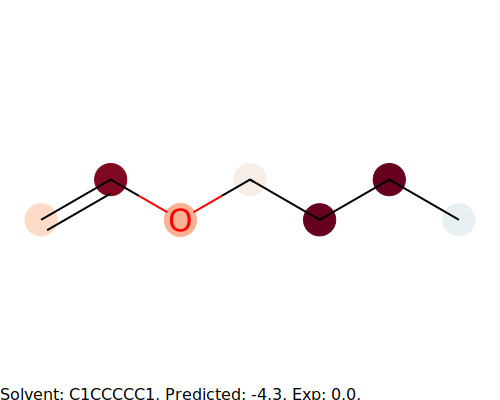

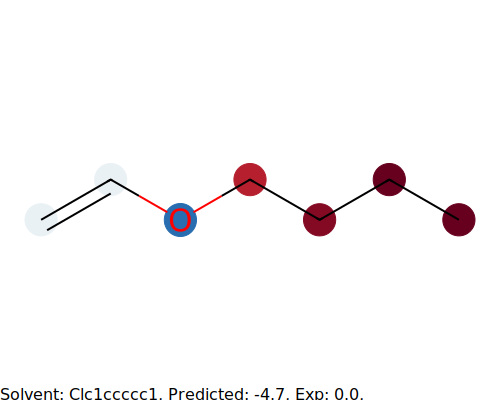

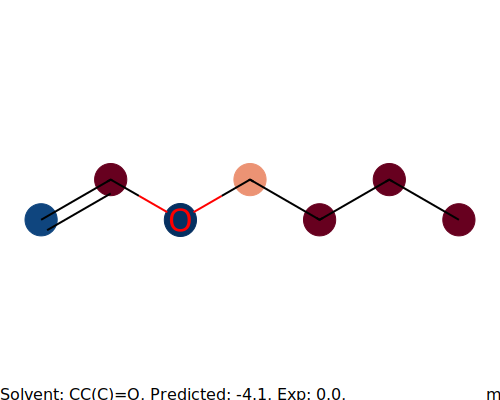

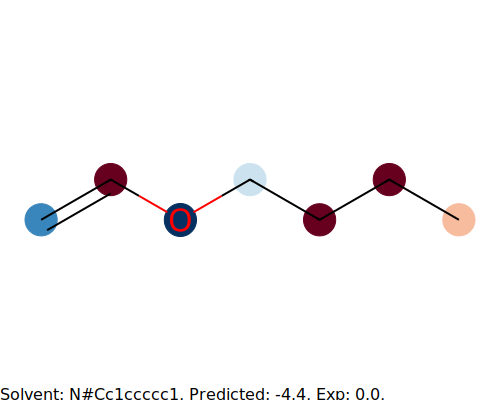

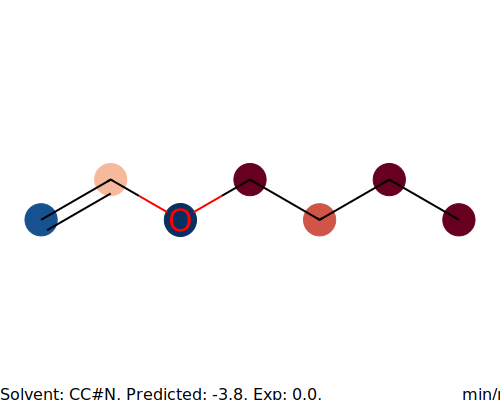

In [7]:
df_of_interest = df[df.label.str.contains('rxn534_r2')]


for _, row in df_of_interest.iterrows():
    #if row['can_smiles_solute'] == 'C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C@@H]2O':
    if True:
        svg, m = draw_shap(row)
        display(svg)
    
    #if _ == 20: break

In [8]:
df_of_interest

,can_smiles_solute,can_smiles_solvent,DGsolv,label,predicted,total_atoms_solute,total_atoms_solvent,shap_values,Shap_contrib,pred_from_shap_sum
197,C=COCCCC,C1CCCCC1,0.0,rxn534_r2,-4.299685,7,6,[ 0.875037 0.14301452 0.71943255 1.008116...,"[-0.1922222857142858, -0.9242447657142857, -0....",-4.299434
200,C=COCCCC,Clc1ccccc1,0.0,rxn534_r2,-4.654121,7,7,[ 1.13722206 1.13751703 1.83092802 0.286581...,"[0.06996277428571429, 0.07025774428571419, 0.7...",-4.654355
203,C=COCCCC,CC(C)=O,0.0,rxn534_r2,-4.138436,7,4,[ 1.98413966 -0.19945296 3.66337443 0.619176...,"[0.9168803742857143, -1.2667122457142859, 2.59...",-4.138439
206,C=COCCCC,N#Cc1ccccc1,0.0,rxn534_r2,-4.372317,7,8,[ 1.72230762 -0.65868085 2.47526538 1.283462...,"[0.6550483342857143, -1.7259401357142856, 1.40...",-4.372612
209,C=COCCCC,CC#N,0.0,rxn534_r2,-3.844392,7,3,[ 1.93958106 0.74262521 4.85581352 -0.476822...,"[0.8723217742857143, -0.3246340757142857, 3.78...",-3.844095


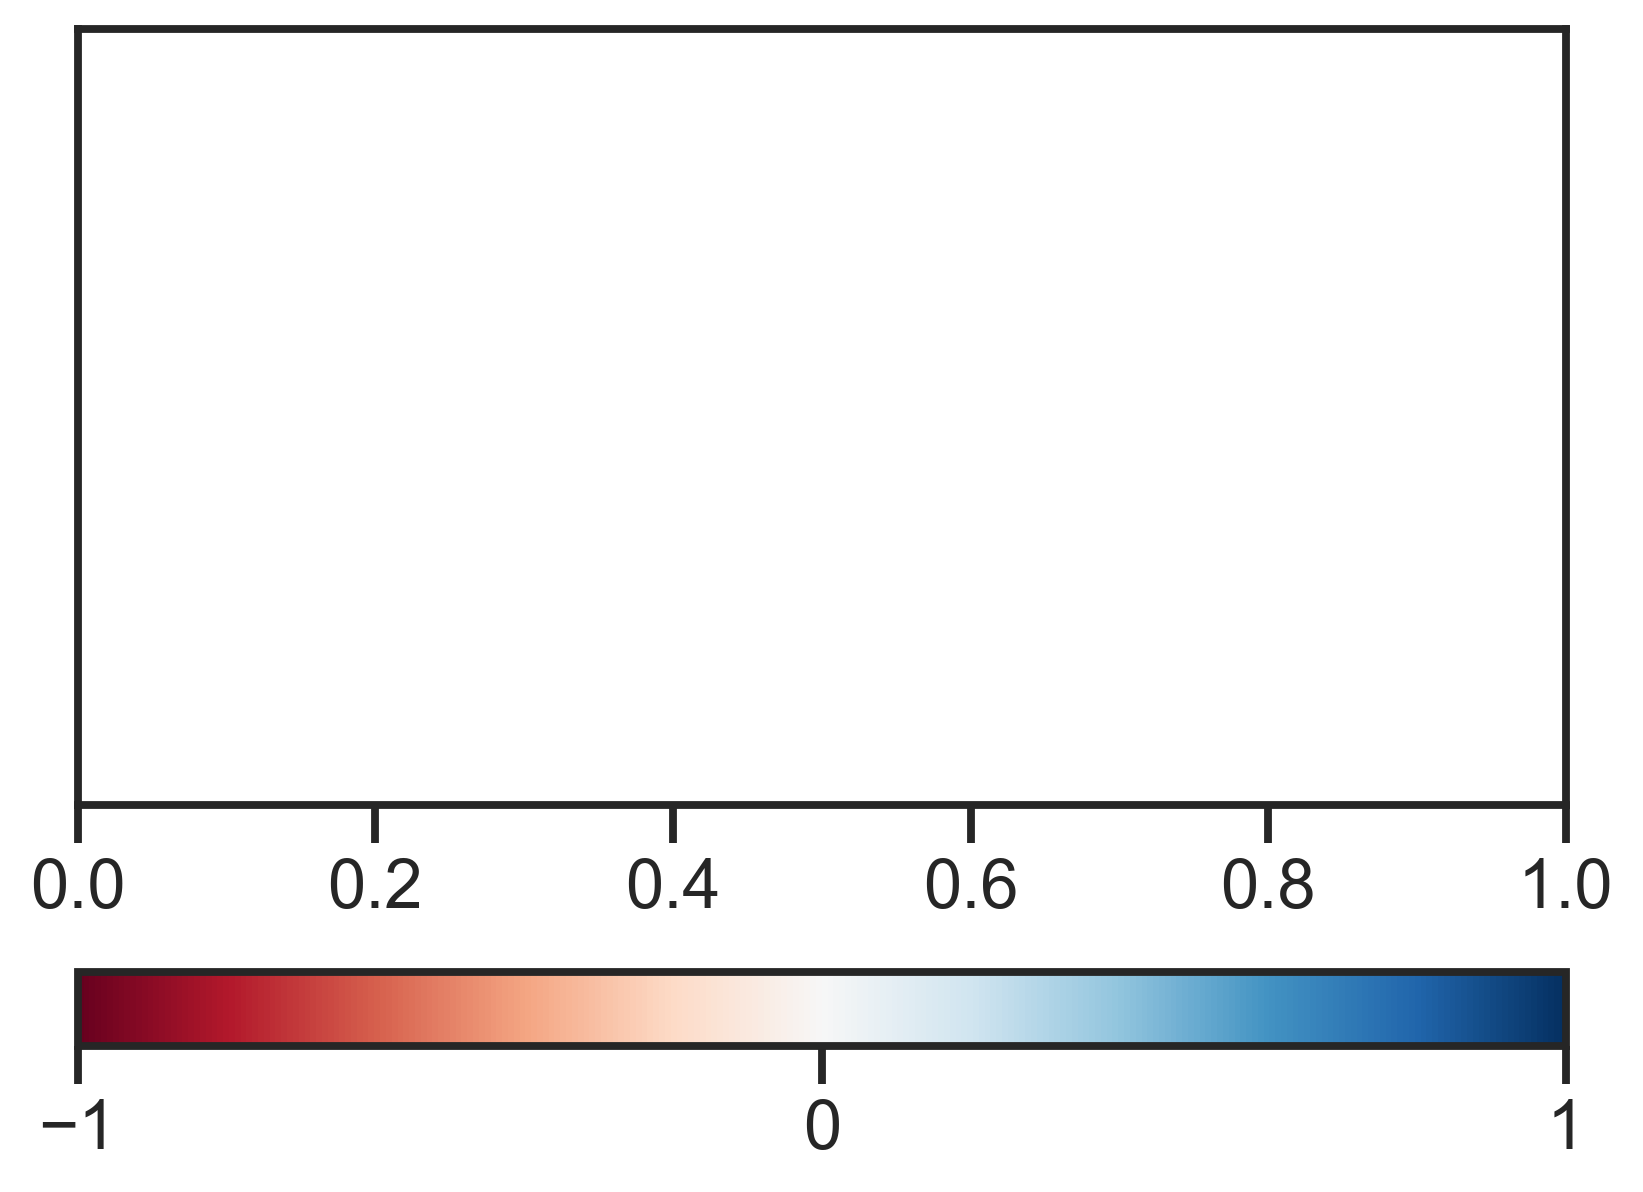

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_yticks([])
plt.colorbar(m, ax=[ax], location='bottom', ticks=[-1.0, 0.0, 1.0])

In [10]:
df

,can_smiles_solute,can_smiles_solvent,DGsolv,label,predicted,total_atoms_solute,total_atoms_solvent,shap_values,Shap_contrib,pred_from_shap_sum
0,O=C1C=CC(=O)O1,Clc1ccccc1Cl,0.0,rxn8_r1,-6.260494,7,8,[ 0.50308142 -0.28108607 0.49260732 0.492607...,"[-0.5641778657142857, -1.3483453557142857, -0....",-6.260485
1,CC1=CCC2C(=O)OC(=O)C2C1,Clc1ccccc1Cl,0.0,rxn8_p1,-10.392890,12,8,[-0.88093452 -2.50393994 -0.00469713 0.358694...,"[-1.5035024366666667, -3.1265078566666666, -0....",-10.392517
2,C=CC(=C)C,Clc1ccccc1Cl,0.0,rxn8_r2,-3.046215,5,8,[-0.32084407 -1.09228783 2.83642323 1.769741...,"[-1.8150070699999998, -2.58645083, 1.34226023,...",-3.046085
3,O=C1C=CC(=O)O1,Clc1cccc(Cl)c1,0.0,rxn8_r1,-6.152175,7,8,[ 0.45258114 -0.14395263 0.415714 0.415714...,"[-0.6146781457142858, -1.2112119157142858, -0....",-6.152644
4,CC1=CCC2C(=O)OC(=O)C2C1,Clc1cccc(Cl)c1,0.0,rxn8_p1,-10.218453,12,8,[-0.88035622 -2.52780863 0.03709792 0.370622...,"[-1.5029241366666666, -3.1503765466666667, -0....",-10.218060
...,...,...,...,...,...,...,...,...,...,...
265,C12CCCCC1O2,ClCCl,0.0,rxn531_p2,-6.018484,7,3,[ 3.20157589 2.85313624 4.02545035 4.02...,"[2.134316604285714, 1.7858769542857142, 2.9581...",-6.018518
266,O=C(OO)C1=CC=CC=C1,ClC(Cl)Cl,0.0,rxn531_r1,-8.728682,10,4,[ 0.49296603 0.33448044 0.60337952 0.083371...,"[-0.25411546999999995, -0.41260105999999996, -...",-8.727494
267,O=C(O)C1=CC=CC=C1,ClC(Cl)Cl,0.0,rxn531_p1,-7.784437,9,4,[ 2.01996273 -3.60264464 2.11832852 -2.837925...,"[1.1898721744444445, -4.432735195555555, 1.288...",-7.785521
268,C1=CCCCC1,ClC(Cl)Cl,0.0,rxn531_r2,-4.603443,6,4,[ 0.97178482 0.97178482 0.63450433 -0.172840...,"[-0.27335101333333334, -0.27335101333333334, -...",-4.603919
